In [1]:
#tu sem omejil na tiste kupili vec kot 12x in napovedal samo 10 izdelkov z najvisjo vrjetnostjo

In [2]:
#importi
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import date, timedelta
import operator

In [3]:
print("loading artikli.csv...")
products = pd.read_csv("Podatki/artikli.csv", dtype={
        'artikel': np.int32,
        'naziv': 'category',
        'neto_kolicina': np.float,
        'em_net_kolicina': 'category',
        'bz_naziv_osnovna': 'category',
        'sbs_1': 'category',
        'sbs_2': 'category',
        'sbs_3': 'category',
        'sbs_4': 'category',
        'sbs_5': 'category',
        'sbs_6': 'category',
        'cat_1': 'category',
        'cat_2': 'category',
        'cat_3': 'category',
        'cat_4': 'category'})

parse_dates = ['datum']

print("loading nakupi.csv...")
orders = pd.read_csv("Podatki/nakupi.csv",dtype={ #nrows=500000
        'kupec': np.uint32,
        'st_racuna': np.uint32,
        'artikel': np.uint32,
        'letak': np.bool},
        parse_dates=parse_dates)
print("done")

loading artikli.csv...
loading nakupi.csv...
done


In [4]:
valid_users = pd.DataFrame()

valid_users['n_orders'] = orders.groupby('kupec')['st_racuna'].nunique()
valid_users = valid_users.assign(is_valid=valid_users.n_orders > 6)
orders = pd.merge(orders, valid_users, on='kupec')
orders = orders.loc[orders['is_valid'] == True] # ali ima kupec dovolj nakupov /ostale izlocimo

In [5]:
#Preparing data sets train/test
print("Preparing data sets train/test...")
user_list = orders['kupec'].unique() # delitev 90% : 10%
msk = np.random.rand(len(user_list)) < 0.9
users_train = user_list[msk]
users_test = user_list[~msk]

tmp = pd.DataFrame()
test = pd.DataFrame()
orders['last_order'] = orders.groupby('kupec')['st_racuna'].transform(max)
tmp = orders.assign(test=orders.st_racuna == orders.last_order)

### TRAIN ###
train_for_index = orders.set_index(['st_racuna', 'artikel'], inplace=False, drop=False) #tu ne odstranim po kupcih ker potrebujem vse pare nakup izdelek da vem modelu povedat kaj je potem dejansko kupil tisti train_index
train = tmp.loc[tmp['test'] == False] # ali je zadnji nakup ali ne
train = train.loc[train['kupec'].isin(users_train)] #filtrira na test/train
#train = train.drop_duplicates(subset=['kupec'], keep='last', inplace=False)
train.drop(train.columns[[1, 4, 5, 6]], axis=1, inplace=True)
train.set_index(['st_racuna', 'artikel'], inplace=True, drop=False)

train_last = tmp.loc[tmp['test'] == True]
train_last = train_last.loc[train_last['kupec'].isin(users_train)] #filtrira na test/train
#train_for_index = train_last.set_index(['st_racuna', 'artikel'], inplace=False, drop=False) #tu ne odstranim po kupcih ker potrebujem vse pare nakup izdelek da vem modelu povedat kaj je potem dejansko kupil tisti train_index
train_last = train_last.drop_duplicates(subset='kupec')
train_last.drop(train_last.columns[[1, 3, 4, 5, 6]], axis=1, inplace=True) 
train_last.set_index(['st_racuna'], inplace=True, drop=False)

### TEST ###
test = tmp.loc[tmp['test'] == False] # zadnji kupec ali ne
test = test.loc[test['kupec'].isin(users_test)] # filtrira na test/train
#test = test.drop_duplicates(subset=['kupec'], keep='last', inplace=False)
test.drop(test.columns[[1, 4, 5, 6]], axis=1, inplace=True)
test.set_index(['st_racuna', 'artikel'], inplace=True, drop=False)

test_last = tmp.loc[tmp['test'] == True]
test_last = test_last.loc[test_last['kupec'].isin(users_test)] #filtrira na test/train
test_for_f1 = test_last
test_last = test_last.drop(test_last.columns[[3, 4, 5, 6]], axis=1, inplace=False)
test_last = test_last.drop_duplicates(subset='kupec')
test_last.set_index(['st_racuna'], inplace=True, drop=False)

#test_for_f1.drop(test_for_f1.columns[[1, 4, 5, 6]], axis=1, inplace=True)
test_for_f1 = test_for_f1.groupby('st_racuna').agg({'artikel':lambda x: list(x), 'datum': 'first'}) # transforms real artikels to list
print("done")

Preparing data sets train/test...
done


In [6]:
### product features ###
print("calculating product features...")
prodf = pd.DataFrame()
prodf['orders'] = orders.groupby(orders.artikel).size().astype(np.int32) #number of orders
newReorders = orders.groupby(['kupec', 'artikel']).size().reset_index(name='reordersUser').astype(np.float32)#number of reorders
newReorders = newReorders[newReorders['reordersUser'] > 1]
prodf['reorders'] = newReorders.groupby(['artikel'])['reordersUser'].sum().astype(np.float32)
prodf = prodf.fillna(0)
prodf['reorder_rate'] = (prodf.reorders / prodf.orders).astype(np.float32) # ratio of reorders
products = products.join(prodf, on='artikel')
products.set_index('artikel', drop=False, inplace=True)
del prodf

print("done")

calculating product features...
done


In [7]:
products.head(1)

,artikel,naziv,neto_kolicina,em_neto_kolicina,bz_naziv_osnovna,sbs_1,sbs_2,sbs_3,sbs_4,sbs_5,sbs_6,cat_1,cat_2,cat_3,cat_4,orders,reorders,reorder_rate
artikel,,,,,,,,,,,,,,,,,,
0,0,Rozine zlate odlično 250g KOS,0.25,KG,Odlično,03 Sadje in zelenjava,03-03 Sadje suho in oreščki,03-03-01 Konvencionalno suho sadje in oreščki,03-03-01-02 Suho sadje in oreščki - pakirano,03-03-01-02-01 Suho sadje pakirano,03-03-01-02-01-03 Rozine suhe pakirane,02 Sadje in zelenjava,0203 Suho sadje in zelenjava,020302 Suho sadje pak,02030203 Suhe rozine pakirane,859.0,387.0,0.450524


In [8]:
### user features ###
print("calculating user features...")
usr = pd.DataFrame()
nc = orders.drop_duplicates(subset=['kupec', 'datum'])
nc['previous_visit'] = nc.groupby(['kupec'])['datum'].shift()
nc['days_bw_visits'] = nc['datum'] - nc['previous_visit']
nc['days_bw_visits'] = nc['days_bw_visits'].apply(lambda x: x.days)
usr['average_days_between_orders'] = nc.groupby('kupec')['days_bw_visits'].agg('mean') #average days between orders
usr['nb_orders'] = orders.groupby('kupec')['st_racuna'].nunique().astype(np.int16) #number of orders
usr['last_order'] = orders.groupby('kupec')['st_racuna'].max()


users = pd.DataFrame()
nc = orders.drop_duplicates(subset=['kupec', 'artikel'])
users['total_items'] = orders.groupby(['kupec']).size() #total items bought by user
users['all_products'] = orders.groupby('kupec').agg({'artikel':lambda x: set(x)}) #set of products(id) bought  by this user!!!
users['total_distinct_items'] = users['all_products'].apply(len).astype(np.int16) #number of distinct items bought
users['user_items_from_letak'] = orders.groupby(['kupec'])['letak'].sum().astype(np.int16) #koliko izdelkov je kupil iz letaka
users['user_items_from_letak_ratio'] = users['user_items_from_letak']/users['total_items'] # koliko je razmerje izdelkov iz letaka ki jih  je kupil

users = users.join(usr)
del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32) #avg number of items in order
print('user f', users.shape)
print("done")

calculating user features...
user f (19480, 9)
done


In [9]:
users.head(1)

,total_items,all_products,total_distinct_items,user_items_from_letak,user_items_from_letak_ratio,average_days_between_orders,nb_orders,last_order,average_basket
kupec,,,,,,,,,
0,217,"{6657, 2, 7, 7182, 2575, 17, 531, 25, 1564, 25...",147,21,0.096774,8.684211,22,875198,9.863636


In [10]:
### userXproduct features ###

print('calculating userXproduct features... slow...')
orders['user_product'] = orders.artikel + orders.kupec * 100000 #user_product id
orders['user_max_st_racuna'] = orders.groupby('kupec')['st_racuna'].transform(max)

#make dict of user-product entitys (vsak par kupec-izdelek, pod pogojem da je sploh kupil izdelek 1x)
d= dict()
for row in orders.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                row.st_racuna,
                1 if row.st_racuna > row.user_max_st_racuna-5 else 0)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1],row.st_racuna),
                d[z][2]+1 if row.st_racuna > row.user_max_st_racuna-5 else d[z][2])

print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'total_buys_n5']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x).astype(np.int32)
userXproduct.total_buys_n5 = userXproduct.total_buys_n5.astype(np.int16)
print('user X product f', len(userXproduct))

print("done")

calculating userXproduct features... slow...
to dataframe (less memory)
user X product f 3499008
done


In [11]:
userXproduct.head(1)

,nb_orders,last_order_id,total_buys_n5
21000000,1,0,0


In [13]:
### build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    in_letak_list = []
    train_index = set(train_for_index.index)  
    i = 0 
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        user_id = row.kupec
        order_id = row.st_racuna
        user_prods = users['all_products'][user_id]
        product_list += user_prods
        order_list += [order_id] * len(user_prods)
        if labels_given:
            labels += [(order_id, prod) in train_index for prod in user_prods]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.kupec)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    df['user_last_order'] = df.user_id.map(users.last_order)
    df['user_items_from_letak'] = df.user_id.map(users.user_items_from_letak)
    df['user_items_from_letak_ratio'] = df.user_id.map(users.user_items_from_letak_ratio)
    
    print('order related features')
    
    print('product related features')
    df['cat_1'] = df.product_id.map(products.cat_1)
    df['cat_2'] = df.product_id.map(products.cat_2)
    df['cat_3'] = df.product_id.map(products.cat_3)
    df['cat_4'] = df.product_id.map(products.cat_4)
    df['sbs_1'] = df.product_id.map(products.sbs_1)
    df['sbs_2'] = df.product_id.map(products.sbs_2)
    df['sbs_3'] = df.product_id.map(products.sbs_3)
    df['sbs_4'] = df.product_id.map(products.sbs_4)
    df['sbs_5'] = df.product_id.map(products.sbs_5)
    df['sbs_6'] = df.product_id.map(products.sbs_6)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_total_buys_n5'] = df.z.map(userXproduct.total_buys_n5)

    values = {'UP_orders': 0, 'UP_orders_ratio': 0, 'UP_total_buys_n5': 0}
    df = df.fillna(value=values)
    return (df, labels)
    

df_train, labels = features(train_last, labels_given=True)

f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
        'user_items_from_letak', 'user_items_from_letak_ratio',
        'cat_1','cat_2','cat_3','cat_4', 'sbs_1', 'sbs_2', 'sbs_3', 'sbs_4', 'sbs_5', 'sbs_6',
        'product_orders', 'product_reorders',
        'product_reorder_rate', 'UP_orders', 'UP_orders_ratio', 'UP_total_buys_n5']


print('formating for lgb')
d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['cat_1', 'cat_2', 'cat_3', 'cat_4', 'sbs_1', 'sbs_2', 'sbs_3'
                                           , 'sbs_4', 'sbs_5', 'sbs_6'])
del df_train

params = {
    'task': 'train',
    'boosting_type': 'gbdt', 
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'max_depth': 8,
    'num_leaves': 128, #256 ali 128
    'min_data_in_leaf': 30, #512 ali 30
    'max_bin': 32,
    'learning_rate': 0.025,
    'num_iterations': 600,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}
#     'num_leaves': 96,
#     'max_depth': 10,
#     'bagging_fraction': 0.95,
#     'bagging_freq': 5,
ROUNDS = 120

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)
#lgb.plot_importance(bst, figsize=(9,20)) #importance plot
del d_train
print("done")

build candidate list
order row 10000
user related features
order related features
product related features
user_X_product related features
formating for lgb
light GBM train :-)
done


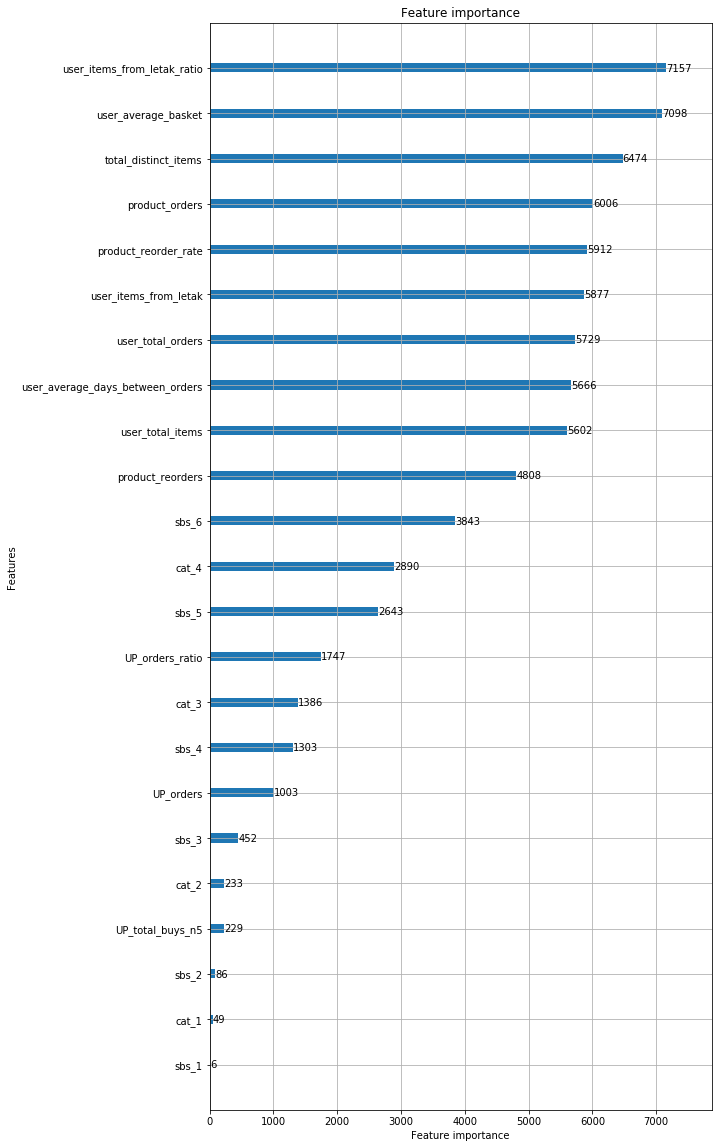

In [27]:
lgb.plot_importance(bst, figsize=(9,20)) #importance plot

In [14]:
### build candidates list for test ###

df_test, _ = features(test_last)

print('light GBM predict')
preds = bst.predict(df_test[f_to_use])

df_test['pred'] = preds

TRESHOLD = 0.00 #0.07

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id].append((row.product_id, row.pred))
        except:
            d[row.order_id] = [(row.product_id, row.pred)]

for order in test_last.st_racuna:
    if order not in d:
        d[order] = 'None'

d_2 = dict()
for key in d:
    d_2[key] = str(d[key])
sub = pd.DataFrame.from_dict(d_2, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['st_racuna', 'artikli']
sub.to_csv('my_sub.csv', index=False)
print("done")

build candidate list
user related features
order related features
product related features
user_X_product related features
light GBM predict
done


(array([3.12019e+05, 4.15320e+04, 5.67700e+03, 1.11300e+03, 4.52000e+02,
        3.39000e+02, 2.10000e+01, 3.00000e+00, 3.00000e+00, 5.00000e+00]),
 array([2.18118052e-04, 5.80348455e-02, 1.15851573e-01, 1.73668300e-01,
        2.31485028e-01, 2.89301755e-01, 3.47118483e-01, 4.04935210e-01,
        4.62751938e-01, 5.20568665e-01, 5.78385393e-01]),
 <a list of 10 Patch objects>)

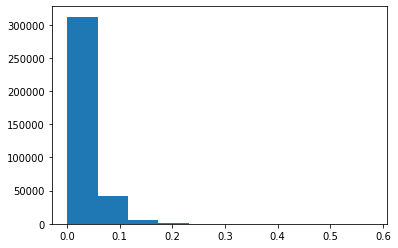

In [15]:
plt.hist(preds)

In [34]:
### TESTING ####

def eval_fun(labels, preds, st_racuna):
    labels = labels
    preds = d.get(st_racuna, [])
    if preds != 'None':
        preds.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
    preds_top = []
    for i in range(0,10):
        if i < len(preds):
            preds_top.append(preds[i][0])
    rr = (np.intersect1d(labels, preds_top))
    precision = np.float(len(rr)) / len(preds_top)
    recall = np.float(len(rr)) / len(labels)
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        return (precision, recall, 0.0)
    return (precision, recall, f1)


###########
#test_for_f1['artikel'] = test_for_f1['artikel'].astype(str)
cv_preds_df = pd.read_csv('my_sub.csv')
cv_preds_df['artikli'] = cv_preds_df['artikli'].astype(str)
test_for_f1 = pd.merge(test_for_f1, cv_preds_df, how='left', on='st_racuna')
print("done")
len(test_for_f1)

done


2013

In [35]:
res = list()
for entry in test_for_f1.itertuples():
    res.append(eval_fun(entry[2], entry[4], entry[1]))

res = pd.DataFrame(np.array(res), columns=['precision', 'recall', 'f1'])

In [36]:
res.describe()

,precision,recall,f1
count,2013.000000,2013.000000,2013.000000
mean,0.134675,0.242453,0.151285
std,0.127211,0.262096,0.133290
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.100000,0.166667,0.142857
75%,0.200000,0.333333,0.235294
max,0.700000,1.000000,0.736842


In [19]:
### F-Score samo z izdelki iz letaka ###

In [20]:
#naredimo dict z izdelki iz letaka
print('Making letak dict...')
letak_d= dict()
for row in orders.itertuples():
    datum = row.datum
    if row.letak == True:
        if datum.weekday() == 0:   #pon
            datum = datum - timedelta(4)
        elif datum.weekday() == 1: #tor
            datum = datum - timedelta(5)
        elif datum.weekday() == 2: #sre
            datum = datum - timedelta(6)
        elif datum.weekday() == 4: #pet
            datum = datum - timedelta(1)
        elif datum.weekday() == 5: #sob
            datum = datum - timedelta(2)
        elif datum.weekday() == 6: #ned
            datum = datum - timedelta(3)
        if datum.weekday() == 3:   #letak se začne s četrtkom
            if datum not in letak_d:
                letak_d[datum] = {row.artikel}
            else:
                letak_d[datum].add(row.artikel)
print('done')

Making letak dict...
done


In [31]:
def letak_eval_fun(labels, letak, st_racuna):
    preds = d.get(st_racuna, [])
    if preds != 'None':
        preds.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
    preds_top = []
    for i in range(0,5):
        if i < len(preds):
            preds_top.append(preds[i][0])
    preds_letak_top = (np.intersect1d(preds_top, letak))
    rr = (np.intersect1d(labels, preds_letak_top))
    precision = 0
    recall = 0
    try:
        precision = np.float(len(rr)) / len(preds_letak_top)
        recall = np.float(len(rr)) / len(labels)
        f1 = 2 * precision * recall / (precision + recall)
        #print("   p={0:.2f} r={0:.2f} f={0:.2f} preds: ".format(precision, recall, f1, preds) + str(rr))
    except ZeroDivisionError:
        return (precision, recall, 0.0)
    return (precision, recall, f1)

In [32]:
res_letak = list()
for entry in test_for_f1.itertuples():
    datum = entry[3] #datum
    if datum.weekday() == 0:   #pon
        datum = datum - timedelta(4)
    elif datum.weekday() == 1: #tor
        datum = datum - timedelta(5)
    elif datum.weekday() == 2: #sre
        datum = datum - timedelta(6)
    elif datum.weekday() == 4: #pet
        datum = datum - timedelta(1)
    elif datum.weekday() == 5: #sob
        datum = datum - timedelta(2)
    elif datum.weekday() == 6: #ned
        datum = datum - timedelta(3)
    labels = entry[2]
    preds = entry[4].split(' ')
    st_racuna = entry[1]
    letak = list(letak_d[datum])
    labels_letak = (np.intersect1d(labels, letak))
    preds_letak = (np.intersect1d(preds, letak))
    
    res_letak.append(letak_eval_fun(labels_letak, letak, st_racuna))

res_letak = pd.DataFrame(np.array(res_letak), columns=['precision', 'recall', 'f1'])

In [33]:
res_letak.describe()

,precision,recall,f1
count,2013.000000,2013.000000,2013.000000
mean,0.174425,0.143948,0.143487
std,0.348934,0.308363,0.292482
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000
